In [44]:
import numpy as np, torch, matplotlib.pyplot as plt
import os
import sys

current_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_dir, "../src"))

if module_path not in sys.path:
    sys.path.append(module_path)

dpo_path = '../src/best_dpo_policy.pth'

horizon = 100
horizon_base = 200

Creating Path with step 3
Resetting environment. Previous state: [0.05 0.05], Counter: 0


/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_49534/2868436029.py:280: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  two_score   = float(scores[idx_best2])


Step called. Counter: 0, Horizon: 100
Step called. Counter: 1, Horizon: 100
Step called. Counter: 2, Horizon: 100
Step called. Counter: 3, Horizon: 100
Step called. Counter: 4, Horizon: 100
Step called. Counter: 5, Horizon: 100
Step called. Counter: 6, Horizon: 100
Step called. Counter: 7, Horizon: 100
Step called. Counter: 8, Horizon: 100
Step called. Counter: 9, Horizon: 100
Step called. Counter: 10, Horizon: 100
Step called. Counter: 11, Horizon: 100
Step called. Counter: 12, Horizon: 100
Step called. Counter: 13, Horizon: 100
Step called. Counter: 14, Horizon: 100
Step called. Counter: 15, Horizon: 100
Step called. Counter: 16, Horizon: 100
Step called. Counter: 17, Horizon: 100
Step called. Counter: 18, Horizon: 100
Step called. Counter: 19, Horizon: 100
Step called. Counter: 20, Horizon: 100
Step called. Counter: 21, Horizon: 100
Step called. Counter: 22, Horizon: 100
Step called. Counter: 23, Horizon: 100
Step called. Counter: 24, Horizon: 100
Step called. Counter: 25, Horizon: 

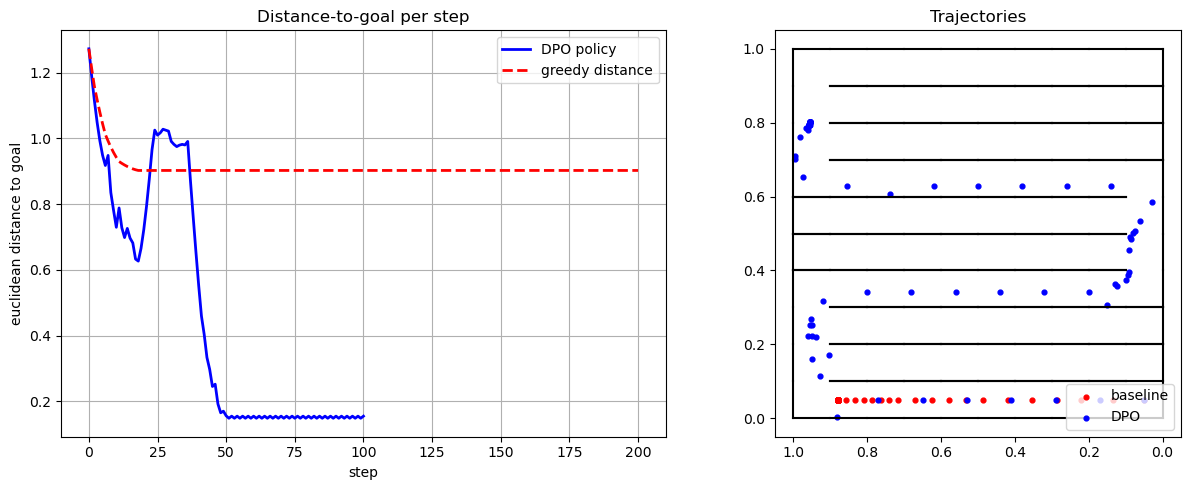

In [45]:
import numpy as np, torch, matplotlib.pyplot as plt
from maze import Maze
from maze_env import MazeEnv, draw_map
from maze_env import PolicyNetwork

# utils.py (o direttamente in make_comparison.ipynb)

def best_improving_action(env, acts, ref_metric, tol=1e-6):
    """
    Ritorna la prima azione che riduce di almeno `tol`
    il valore di ref_metric(s') rispetto a quello corrente.
    Se nessuna azione migliora, restituisce None.
    """
    best_a, best_val = None, ref_metric  # migliore finora (deve essere < ref)
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        s1 = env.state + np.array([dx, dy])

        # qui usiamo la distanza al goal come metrica di riferimento
        val = np.linalg.norm(env.goal - s1)

        # opzionale: scarta subito se la mossa collide
        if env.point_collision(s1[0], s1[1]):
            continue

        if val < best_val - tol:
            best_val, best_a = val, a

    return best_a

# ------------------------------------------------------------------
# helper: rollout con politica arbitraria f(state) -> action
# ------------------------------------------------------------------
def rollout(env, policy_fn, max_steps=500):
    if max_steps is None:
        max_steps = env.horizon
    env.reset(state=start.copy())
    traj, dists = [env.state.copy()], [np.linalg.norm(env.goal-env.state)]
    for _ in range(max_steps):
        a = policy_fn(env)
        state, _, done, _, _ = env.step(a)
        traj.append(state.copy())
        dists.append(np.linalg.norm(env.goal - state))
        if done:
            break
    return np.array(traj), dists

def policy_dist_safe(env, tol=1e-6):
    acts = candidate_actions()
    cur_d = np.linalg.norm(env.goal - env.state)
    a = best_improving_action(env, acts, cur_d, tol=tol)
    return a if a is not None else np.zeros(2, dtype=np.float32)  # resta fermo


def to_std(x: torch.Tensor) -> torch.Tensor:
    return (x - env_dpo._mean) / env_dpo._std

# ------------------------------------------------------------------
# 1. ambiente + DPO-policy caricata
# ------------------------------------------------------------------
hidden_dim = 256
num_layers = 4
dropout_prob = 0.05

start = np.array([0.05, 0.05])
maze  = Maze(10,10,0,0)
env_dpo = MazeEnv(sz=10, maze=maze, start=start, goal=np.array([0.95,0.95]),
                  reward="distance", dt=0.15, horizon=horizon, slide=1,
                  use_dpo=True, dpo_model_path=dpo_path, hidden_dim=hidden_dim, num_layers=num_layers, dropout_prob=dropout_prob)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#  --- costanti usate nel training ---
norm = np.load("norm_stats.npz")
MEAN = norm["mean"].astype(np.float32)     # shape (2,)
STD  = norm["std"].astype(np.float32) + 1e-8   # per evitare div/0

def get_norm_tensors(device):
    if not hasattr(get_norm_tensors, "_cache"):
        get_norm_tensors._cache = {}
    if device not in get_norm_tensors._cache:
        get_norm_tensors._cache[device] = (
            torch.tensor(MEAN, device=device),   # <<== torch sul device giusto
            torch.tensor(STD,  device=device)
        )
    return get_norm_tensors._cache[device]

# ---- normalizzazione per l'inferenza ----
def _std(x: torch.Tensor) -> torch.Tensor:
    mean_t, std_t = get_norm_tensors(x.device)   # mai numpy qui
    return (x - mean_t) / std_t

def is_legal(env, s_from, s_to, n=4):
    """Vero se il segmento s_from→s_to non tocca muri."""
    alphas = np.linspace(0., 1., n)
    for a in alphas:
        p = (1-a)*s_from + a*s_to
        if env.collision(p):          # oppure env.point_collision(*p)
            return False
    return True

# ------------------------------------------------------------------
# 2. definisci le due politiche
# ------------------------------------------------------------------
angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
speeds = [0.05, 0.1, 0.2, 0.4, 0.8]                    

def candidate_actions():
    a, s = np.meshgrid(angles, speeds)
    return np.stack([s.ravel(), a.ravel()], axis=1)

# -- DPO: valuta con la rete -----------------------
def policy_dpo(env):
    acts = candidate_actions()
    next_states_raw = []
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        next_states_raw.append(env.state + np.array([dx,dy]))
    # --- inferenza ---
    x = torch.tensor(next_states_raw, dtype=torch.float32, device=device)
    x_std = _std(x)                         # <-- aggiunto
    with torch.no_grad():
        scores = env.policy_net(x_std).cpu().numpy().squeeze()
    return acts[np.argmax(scores)]


def policy_dpo_safe(env, tol_val=1e-3):
    """
    Seleziona l’azione con punteggio più alto che non collide.
    Se più azioni hanno lo stesso punteggio usa la distanza euclidea
    al goal come tie‑breaker.  Se *tutte* le mosse collidono
    (succede raramente), restituisce (0,0).
    """
    acts = candidate_actions()

    legal = [a for a in acts if is_legal(env, env.state,
                                    env.state + a[0] * env.dt *
                                    np.array([np.cos(a[1]*np.pi),
                                              np.sin(a[1]*np.pi)]))]
    print(f"step {env.counter:3d}  legal={len(legal):3d}")

    # -------------------------------------------------------
    # 1) genera in blocco i possibili stati successivi
    # -------------------------------------------------------
    next_states = env.state + np.stack(
        [acts[:, 0] * np.cos(acts[:, 1] * np.pi) * env.dt,
         acts[:, 0] * np.sin(acts[:, 1] * np.pi) * env.dt],
        axis=1
    )

    # normalizza e valuta con la rete
    with torch.no_grad():
        scores = env.policy_net(to_std(torch.as_tensor(next_states,
                                dtype=torch.float32,
                                device=env.device))
        ).cpu().numpy().squeeze()

    # -------------------------------------------------------
    # 2) ordina le azioni per punteggio (decrescente)
    # -------------------------------------------------------
    order = np.argsort(scores)[::-1]        # argmax, arg2max, …

    # -------------------------------------------------------
    # 3) prova la migliore lecita; se c’è un ex‑aequo usa il tie‑breaker
    # -------------------------------------------------------
    best_score = scores[order[0]]
    best_idxs  = order[scores[order] == best_score]

    if len(best_idxs) > 1:
        # tie‑breaker: prende quella che avvicina di più al goal
        best_d, best_a = np.inf, None
        for idx in best_idxs:
            nx, ny = next_states[idx]
            # if is_legal(env, np.array([nx, ny])):
            if is_legal(env, env.state, np.array([nx, ny])):
                d = np.linalg.norm(env.goal - np.array([nx, ny]))
                if d < best_d:
                    best_d, best_a = d, acts[idx]
        if best_a is not None:
            return best_a

    # se non c’era parità o il tie‑breaker non ha scelto
    for idx in order:
        nx, ny = next_states[idx]
        # if not env.collision(env.state, np.array([nx, ny])):
        if is_legal(env, env.state, np.array([nx, ny])):
            return acts[idx]

    # fallback: nessuna mossa lecita → resta fermo
    return np.zeros(2, dtype=np.float32)

def lookahead_action(env, depth=4, beam_width=8):
    """
    Valuta tutte le sequenze di lunghezza `depth` usando beam‑search.
    • beam_width = quanti candidati tenere a ogni livello
    • ritorna la PRIMA azione della sequenza migliore
    """
    acts = candidate_actions()
    start_val = env.evaluate_state_with_dpo(env.state)

    # stato cumulativo = (valore_finale, prima_azione, stato_attuale)
    beam = []
    for a in acts:
        nx = env.state + a[0]*env.dt*np.array([np.cos(a[1]*np.pi),
                                               np.sin(a[1]*np.pi)])
        if env.point_collision(*nx):      # scarta subito se collide
            continue
        val = env.evaluate_state_with_dpo(nx)
        beam.append((val, a, nx))
    beam.sort(key=lambda x: x[0], reverse=True)
    beam = beam[:beam_width]

    for _ in range(depth-1):
        new_beam = []
        for cum_val, first_a, cur_s in beam:
            for a in acts:
                nx = cur_s + a[0]*env.dt*np.array([np.cos(a[1]*np.pi),
                                                   np.sin(a[1]*np.pi)])
                if env.point_collision(*nx):
                    continue
                val = env.evaluate_state_with_dpo(nx)
                new_beam.append((val, first_a, nx))
        if not new_beam:
            break
        new_beam.sort(key=lambda x: x[0], reverse=True)
        beam = new_beam[:beam_width]

    # migliore sequenza trovata
    best_val, best_a, _ = beam[0]

    # fallback se non migliora di nulla
    if best_val <= start_val + 1e-4:
        return np.zeros(2, dtype=np.float32)
    return best_a

def best_action_two_steps(env, beam_speeds=None):
    """
    Primo passo scelto guardando a due step di profondità.
    Se nessuna coppia (s1, s2) è percorribile, cade su
    “miglior primo passo fra quelli leciti”.
    """
    acts = candidate_actions()                         # (N, 2)

    # ---------- pre‑calcola i possibili s1 ----------
    next_states_1 = env.state + np.stack(
        [acts[:, 0] * np.cos(acts[:, 1] * np.pi) * env.dt,
         acts[:, 0] * np.sin(acts[:, 1] * np.pi) * env.dt],
        axis=1
    )

    best_two_score   = -np.inf   # miglior VALORE con 2 passi leciti
    best_two_action  = None      # → azione da restituire se esiste
    best_one_score   = -np.inf   # miglior VALORE con solo il 1° passo
    best_one_action  = None

    for i, s1 in enumerate(next_states_1):
        # 1° passo deve essere lecito
        if not is_legal(env, env.state, s1):
            continue

        # -------------------------------------------------------
        # valuta *tutti* i secondi passi a partire da s1
        # -------------------------------------------------------
        s2_all = s1 + np.stack(
            [acts[:, 0] * np.cos(acts[:, 1] * np.pi) * env.dt,
             acts[:, 0] * np.sin(acts[:, 1] * np.pi) * env.dt],
            axis=1
        )

        with torch.no_grad():
            scores = env.policy_net(
                _std(torch.tensor(s2_all, dtype=torch.float32,
                                  device=env.device))
            ).cpu().numpy()              # shape (N,)

        # valore migliore raggiungibile in questo ramo
        idx_best2   = scores.argmax()
        two_score   = float(scores[idx_best2])
        s2_best     = s2_all[idx_best2]

        # --- (a) aggiorna il record 2‑passi SOLO se s2 è lecito ---
        if is_legal(env, s1, s2_best) and two_score > best_two_score:
            best_two_score  = two_score
            best_two_action = acts[i]

        # --- (b) aggiorna SEMPRE il record 1‑passo ---------------
        if two_score > best_one_score:
            best_one_score  = two_score
            best_one_action = acts[i]

    # -------------------------------------------------------------
    # restituisci:
    #   • l’azione che apre la MIGLIOR coppia lecita, se esiste
    #   • altrimenti la MIGLIORE azione di primo passo lecita
    # -------------------------------------------------------------
    if best_two_action is not None:
        return best_two_action
    if best_one_action is not None:
        return best_one_action

    # fallback (tutti i primi passi erano illegali – caso rarissimo)
    print(f"‑‑ step {env.counter:3d} → action {best_two_action or best_one_action}")
    return np.zeros(2, dtype=np.float32)

# -- baseline: minimizza distanza euclidea al goal --
def policy_dist(env):
    acts = candidate_actions()
    best, best_d = None, np.inf
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        s  = env.state + np.array([dx,dy])
        d  = np.linalg.norm(env.goal - s)
        # if d < best_d and not env.point_collision(s[0], s[1]):
        if d < best_d and is_legal(env, env.state, s):
            best_d, best = d, a
    return best if best is not None else acts[0]      # fallback

# ------------------------------------------------------------------
# 3. esegui i due roll-out
# ------------------------------------------------------------------
# traj_dpo, dist_dpo = rollout(env_dpo, policy_dpo_safe, max_steps=horizon)
traj_dpo, dist_dpo = rollout(env_dpo, best_action_two_steps, max_steps=horizon)

# traj_dpo, dist_dpo = rollout(env_dpo, policy_dpo, max_steps=horizon)

#  per il baseline usiamo **una nuova copia** dell’ambiente (stesso maze!)
env_base = MazeEnv(sz=10, maze=maze, start=start, goal=np.array([0.95,0.95]),
                   reward="distance", dt=0.15, horizon=horizon_base, slide=1, use_dpo=False)
traj_base, dist_base = rollout(env_base, policy_dist_safe, max_steps=horizon_base)

# ------------------------------------------------------------------
# 4. plotting comparativo
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(13,5))

# --- distanza vs step
axes[0].plot(dist_dpo,  label="DPO policy",  lw=2, color='blue')
axes[0].plot(dist_base, label="greedy distance", lw=2, ls="--", color='red')
axes[0].set_xlabel("step")
axes[0].set_ylabel("euclidean distance to goal")
axes[0].set_title("Distance-to-goal per step")
axes[0].legend(); axes[0].grid(True)

# --- traiettorie
draw_map(1/env_dpo.sz, env_dpo.maze, ax=axes[1], alpha=1.0)

# Traiettoria Baseline (greedy distance) con colore rosso solido
if len(traj_base) > 0:
    axes[1].scatter(traj_base[:,0], traj_base[:,1],
                    color="red",  # Modifica: colore rosso solido
                    s=12, label="baseline")
else:
    axes[1].scatter([],[], color="red", s=12, label="baseline") # Per la legenda se vuota

# Traiettoria DPO con colore blu solido
if len(traj_dpo) > 0:
    axes[1].scatter(traj_dpo[:,0], traj_dpo[:,1],
                    color="blue", # Modifica: colore blu solido
                    s=12, label="DPO")
else:
    axes[1].scatter([],[], color="blue", s=12, label="DPO") # Per la legenda se vuota


axes[1].invert_xaxis(); axes[1].set_aspect("equal")
axes[1].set_title("Trajectories")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

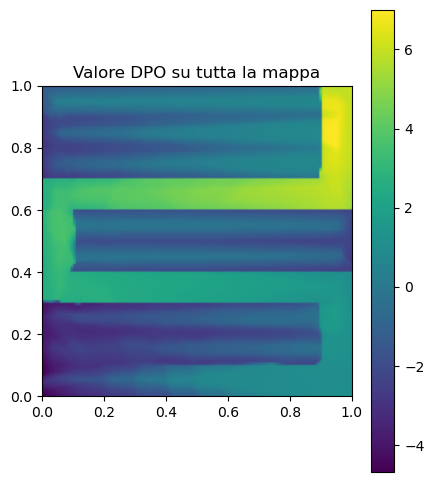

In [46]:
def plot_value_heatmap(env, n=120):
    # campiona n×n punti su tutta la mappa e valuta la rete DPO
    xs = np.linspace(0, 1, n)
    ys = np.linspace(0, 1, n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.stack([xx.ravel(), yy.ravel()], axis=1)
    with torch.no_grad():
        vals = env.policy_net(
            (torch.tensor(pts, device=env.device, dtype=torch.float32)
             - env._mean) / env._std
        ).cpu().numpy().reshape(n, n)
    plt.figure(figsize=(5,6))
    plt.title("Valore DPO su tutta la mappa")
    plt.imshow(vals, origin="lower", extent=[0,1,0,1], cmap="viridis")
    plt.colorbar(); plt.show()

plot_value_heatmap(env=env_dpo)

Text(0.5, 1.0, 'valore DPO lungo la prima riga')

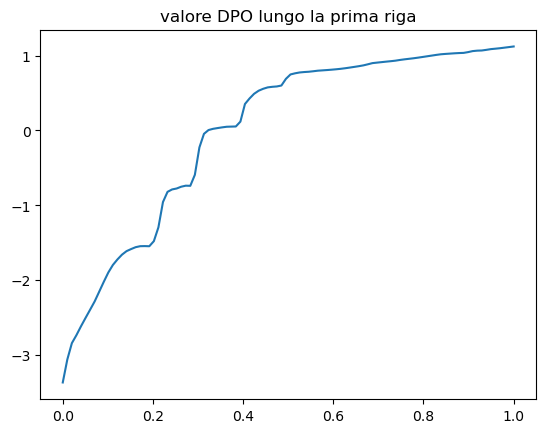

In [47]:
xs = np.linspace(0.0, 1.0, 100)
ys = np.full_like(xs, 0.05)           # y-centre della prima riga
pts = np.column_stack([xs, ys])
with torch.no_grad():
    vals = env_dpo.policy_net(
        (torch.tensor(pts, dtype=torch.float32, device=env_dpo.device) - env_dpo._mean) / env_dpo._std
    ).cpu().numpy()
plt.plot(xs, vals); plt.title("valore DPO lungo la prima riga")


1) Enviroment (preference maze - maze laby with S)
2) greedy fails 
3) the way in which we define the preference function influence a lot the DPO